In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

from ABRA_35.models import CNN
from sklearn.metrics import r2_score
from utils import *
from data_loader import load_data, load_data_2
import seaborn as sns

In [3]:
all_data = load_data_2(verbose=False)
all_data['Synapses_to_IHC_Avg'] = all_data['Synapses to IHC_v1']/2 + all_data['Synapses to IHC_v2']/2
all_data['Orphans_to_IHC_Avg'] = all_data['Orphans to IHC_v1']/2 + all_data['Orphans to IHC_v2']/2

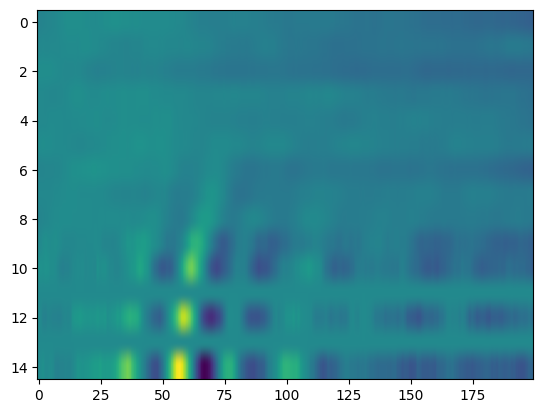

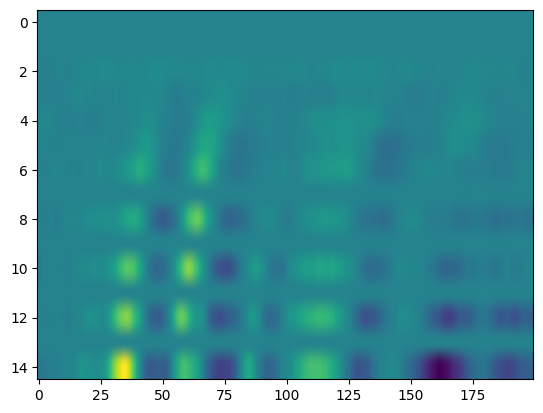

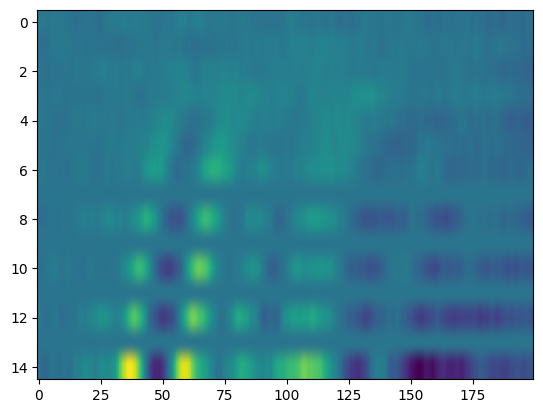

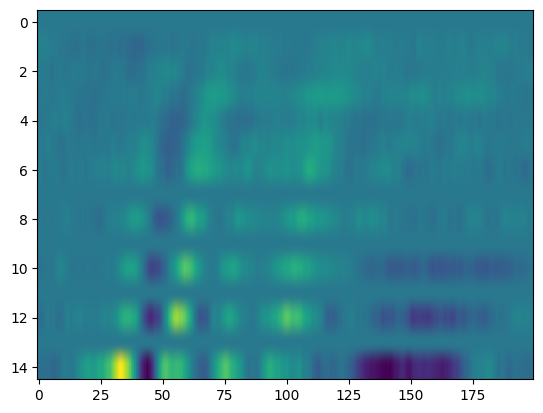

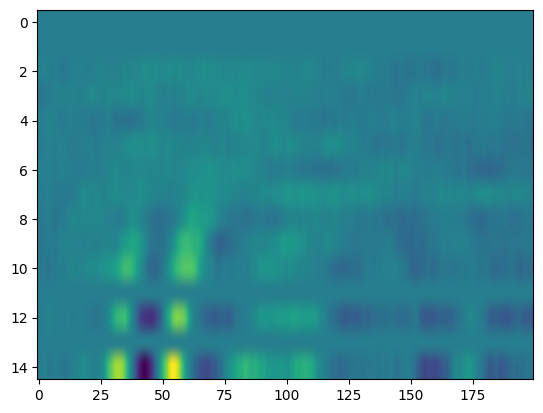

In [21]:
# choose random 5 samples:
samples = all_data.sample(5)

for idx, sample in samples.iterrows():
    plt.imshow(sample['Waveforms'][:,0:200], aspect='auto', cmap='viridis')

    plt.show()

In [6]:
time_scale = 20
from torch.utils.data import Dataset, DataLoader

class WaveformDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.waveforms, self.targets = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        
        for idx, row in df.iterrows():
            waveform = row['Waveforms'][:,0:200]

            waveforms.append(waveform)
            targets.append(row['Synapses_to_IHC_Avg'])
        
        return waveforms, targets

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        return waveform_tensor, target_tensor
    

In [7]:
class WaveformSignatureCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(WaveformSignatureCNN, self).__init__()
        
        # 2D Convolutional layers
        # Input: (batch, 1, n_channels, 200)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 5), padding=(1, 2))  # Preserve spatial dims
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 5), padding=(1, 2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d((2, 4))  # Reduce both channel and time dimensions
        self.pool2 = nn.MaxPool2d((2, 4))
        
        # Global pooling to handle variable input sizes
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        # x shape: (batch, 1, n_channels, 200)
        
        # First conv block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)  # Reduce spatial dimensions
        x = self.dropout(x)
        
        # Second conv block  
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)  # Further reduce spatial dimensions
        x = self.dropout(x)
        
        # Third conv block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        
        # Global pooling to fixed size
        x = self.global_pool(x)  # (batch, 64, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 64)
        
        # Fully connected prediction
        x = self.fc(x)
        return x

# Alternative: Simpler 2D CNN if the above is too complex
class SimpleWaveformSignatureCNN(nn.Module):
    def __init__(self):
        super(SimpleWaveformSignatureCNN, self).__init__()
        
        # Simple 2D conv layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3, 7), padding=(1, 3))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 7), padding=(1, 3))
        
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        
        # Simple FC
        self.fc = nn.Sequential(
            nn.Linear(32, 16),  # 16 + 16 from avg and max pooling
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        # Conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Dual global pooling
        avg_pool = self.global_avg_pool(x).view(x.size(0), -1)  # (batch, 16)
        max_pool = self.global_max_pool(x).view(x.size(0), -1)  # (batch, 16)
        
        # Combine pooled features
        combined = torch.cat([avg_pool, max_pool], dim=1)  # (batch, 32)
        
        # Predict
        output = self.fc(combined)
        return output

def train_2d_cnn_model(train_loader, val_loader, num_epochs=100, 
                       model_type='signature_2d', early_stop=True):
    """
    Train 2D CNN for waveform signatures
    """
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    # Choose model
    if model_type == 'signature_2d':
        model = WaveformSignatureCNN()
    elif model_type == 'simple_2d':
        model = SimpleWaveformSignatureCNN()
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for waveform, target in train_loader:
            waveform, target = waveform.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(waveform)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target in val_loader:
                waveform, target = waveform.to(device), target.to(device)
                output = model(waveform)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()
        
        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Progress
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience and early_stop:
                print(f"Early stopping at epoch {epoch}")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

In [8]:
# Test your dataset and model
from torch.utils.data import DataLoader

# Create dataset
dataset = WaveformDataset(all_data)
print(f"Dataset size: {len(dataset)}")

# Check data shape
sample_waveform, sample_target = dataset[0]
print(f"Waveform shape: {sample_waveform.shape}")  # Should be (1, n_channels, 200)
print(f"Target: {sample_target}")

# Create data loaders
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Test model forward pass
model = SimpleWaveformSignatureCNN()
test_batch = next(iter(train_loader))
test_waveform, test_target = test_batch
print(f"Batch waveform shape: {test_waveform.shape}")

with torch.no_grad():
    test_output = model(test_waveform)
    print(f"Model output shape: {test_output.shape}")
    print(f"Model output: {test_output.squeeze()}")
    print(f"Targets: {test_target}")

print("✅ Setup successful! Ready to train 2D CNN.")

Dataset size: 633
Waveform shape: torch.Size([1, 15, 200])
Target: 9.81944465637207
Batch waveform shape: torch.Size([16, 1, 15, 200])
Model output shape: torch.Size([16, 1])
Model output: tensor([-0.0283,  0.0002, -0.0894, -0.0452, -0.0521, -0.1419, -0.0611, -0.1209,
        -0.0306, -0.0590, -0.0689, -0.0676, -0.0689, -0.0647, -0.0591, -0.0752])
Targets: tensor([ 4.5944, 16.7222, 16.3125,  7.7679, 17.1848, 17.9844, 14.8651, 17.8323,
        17.3889, 14.1000, 15.8921, 18.8365, 15.3514,  1.3728, 11.5725, 17.7683])
✅ Setup successful! Ready to train 2D CNN.


Using device: mps
Epoch 0/100, Train Loss: 221.1131, Val Loss: 212.7483, Best: inf
Epoch 10/100, Train Loss: 29.7961, Val Loss: 17.1514, Best: 12.3422
Epoch 20/100, Train Loss: 30.5049, Val Loss: 12.8013, Best: 11.8981
Epoch 30/100, Train Loss: 32.1762, Val Loss: 10.6488, Best: 11.2967
Epoch 40/100, Train Loss: 25.0703, Val Loss: 13.2161, Best: 10.6488
Epoch 50/100, Train Loss: 26.6794, Val Loss: 13.1830, Best: 10.4928
Epoch 60/100, Train Loss: 23.8952, Val Loss: 11.6705, Best: 10.4928
Early stopping at epoch 66


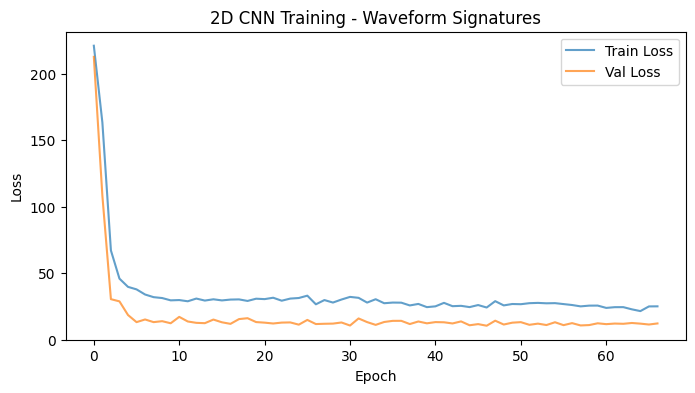

Using device for evaluation: mps


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [11]:
import torch.optim as optim
# Train the 2D CNN
model, train_losses, val_losses = train_2d_cnn_model(
    train_loader, val_loader, 
    num_epochs=100, 
    model_type='simple_2d'  # Start with simple model
)

# Plot training curves
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('2D CNN Training - Waveform Signatures')
plt.show()

# Evaluate
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device for evaluation: {device}")

# Move model to device
model = model.to(device)
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for waveform, target in val_loader:
        waveform, target = waveform.to(device), target.to(device)
        output = model(waveform)
        predictions.extend(output.squeeze().numpy())
        targets.extend(target.numpy())

r2 = r2_score(targets, predictions)
print(f'2D Signature CNN R²: {r2:.3f}')

# Plot predictions
plt.figure(figsize=(6, 6))
plt.scatter(targets, predictions, alpha=0.6)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', alpha=0.5)
plt.xlabel('True Synapse Count')
plt.ylabel('Predicted Synapse Count')
plt.title(f'2D Waveform Signature CNN (R²={r2:.3f})')
plt.show()

Using device for evaluation: mps
2D Signature CNN R²: 0.017


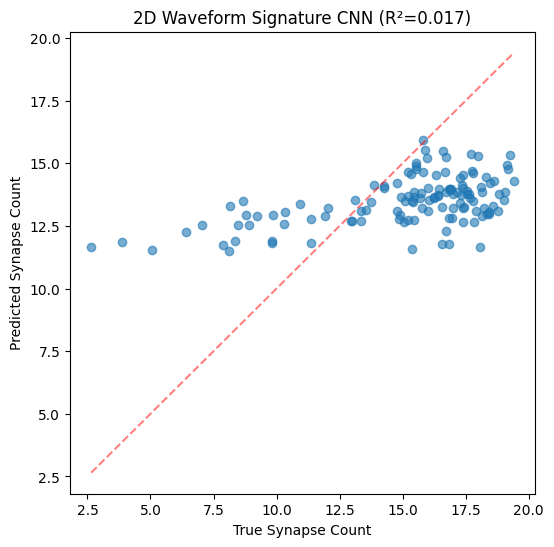

In [12]:

# Evaluate - Fixed version
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device for evaluation: {device}")

# Move model to device
model = model.to(device)
model.eval()
predictions = []
targets = []

with torch.no_grad():
    for waveform, target in val_loader:
        waveform, target = waveform.to(device), target.to(device)
        output = model(waveform)
        
        # Move tensors to CPU before converting to numpy
        predictions.extend(output.squeeze().cpu().numpy())
        targets.extend(target.cpu().numpy())

r2 = r2_score(targets, predictions)
print(f'2D Signature CNN R²: {r2:.3f}')

# Plot predictions
plt.figure(figsize=(6, 6))
plt.scatter(targets, predictions, alpha=0.6)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', alpha=0.5)
plt.xlabel('True Synapse Count')
plt.ylabel('Predicted Synapse Count')
plt.title(f'2D Waveform Signature CNN (R²={r2:.3f})')
plt.show()

In [13]:
class SimpleWaveformSignatureCNN_WithFreq(nn.Module):
    def __init__(self):
        super(SimpleWaveformSignatureCNN_WithFreq, self).__init__()
        
        # Simple 2D conv layers (same as before)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(3, 7), padding=(1, 3))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 7), padding=(1, 3))
        
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        
        # Updated FC layer to include frequency
        self.fc = nn.Sequential(
            nn.Linear(33, 16),  # 32 (pooled features) + 1 (frequency) = 33
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1)
        )
        
    def forward(self, x, frequency):
        # x: waveform tensor (batch, 1, n_channels, 200)
        # frequency: scalar tensor (batch, 1)
        
        # Conv layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Dual global pooling
        avg_pool = self.global_avg_pool(x).view(x.size(0), -1)  # (batch, 16)
        max_pool = self.global_max_pool(x).view(x.size(0), -1)  # (batch, 16)
        
        # Combine pooled features
        waveform_features = torch.cat([avg_pool, max_pool], dim=1)  # (batch, 32)
        
        # Concatenate frequency
        combined_features = torch.cat([waveform_features, frequency], dim=1)  # (batch, 33)
        
        # Predict
        output = self.fc(combined_features)
        return output
    
class WaveformDatasetWithFreq(Dataset):
    def __init__(self, df):
        self.df = df
        self.waveforms, self.targets, self.frequencies = self.prepare_data(df)
    
    def prepare_data(self, df):
        waveforms = []
        targets = []
        frequencies = []
        
        for idx, row in df.iterrows():
            waveform = row['Waveforms'][:,0:200]
            waveforms.append(waveform)
            targets.append(row['Synapses_to_IHC_Avg'])
            
            # Add frequency - adjust column name as needed
            if 'Frequency' in row:
                frequencies.append(row['Frequency'])
            elif 'Freq(Hz) (x1)' in row:
                frequencies.append(row['Freq(Hz) (x1)'])
            else:
                # If no frequency column, you might need to extract from another source
                frequencies.append(1000.0)  # Default or extract from somewhere else
        
        return waveforms, targets, frequencies

    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx].copy()
        
        waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
        target_tensor = torch.tensor(self.targets[idx], dtype=torch.float32)
        freq_tensor = torch.tensor([self.frequencies[idx]], dtype=torch.float32)  # Shape: (1,)
        
        return waveform_tensor, target_tensor, freq_tensor

def train_2d_cnn_model_with_freq(train_loader, val_loader, num_epochs=100, 
                                model_type='simple_with_freq', early_stop=True):
    """
    Train 2D CNN with frequency input
    """
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")

    # Choose model
    if model_type == 'simple_with_freq':
        model = SimpleWaveformSignatureCNN_WithFreq()
    elif model_type == 'advanced_with_freq':
        model = AdvancedWaveformSignatureCNN_WithFreq()
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model = model.to(device)
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    # Early stopping
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for waveform, target, frequency in train_loader:
            waveform = waveform.to(device)
            target = target.to(device)
            frequency = frequency.to(device)
            
            optimizer.zero_grad()
            output = model(waveform, frequency)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for waveform, target, frequency in val_loader:
                waveform = waveform.to(device)
                target = target.to(device)
                frequency = frequency.to(device)
                
                output = model(waveform, frequency)
                loss = criterion(output.squeeze(), target)
                val_loss += loss.item()
        
        # Calculate averages and continue as before...
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience and early_stop:
                print(f"Early stopping at epoch {epoch}")
                break
    
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [14]:
# Create new dataset with frequency
dataset_with_freq = WaveformDatasetWithFreq(all_data)

# Split data
train_size = int(0.8 * len(dataset_with_freq))
val_size = len(dataset_with_freq) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset_with_freq, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Train model with frequency
model_with_freq, train_losses, val_losses = train_2d_cnn_model_with_freq(
    train_loader, val_loader, 
    num_epochs=100, 
    model_type='simple_with_freq'
)

# Evaluate
model_with_freq.eval()
predictions = []
targets = []

with torch.no_grad():
    for waveform, target, frequency in val_loader:
        waveform = waveform.to(device)
        frequency = frequency.to(device)
        
        output = model_with_freq(waveform, frequency)
        predictions.extend(output.squeeze().cpu().numpy())
        targets.extend(target.cpu().numpy())

r2 = r2_score(targets, predictions)
print(f'2D CNN with Frequency R²: {r2:.3f}')

Using device: mps
Epoch 0/100, Train Loss: 9233.2190, Val Loss: 4715.2339
Epoch 10/100, Train Loss: 30.7225, Val Loss: 11.0506
Epoch 20/100, Train Loss: 32.7748, Val Loss: 11.2449
Early stopping at epoch 29
2D CNN with Frequency R²: -0.089


(0.0, 100.0)

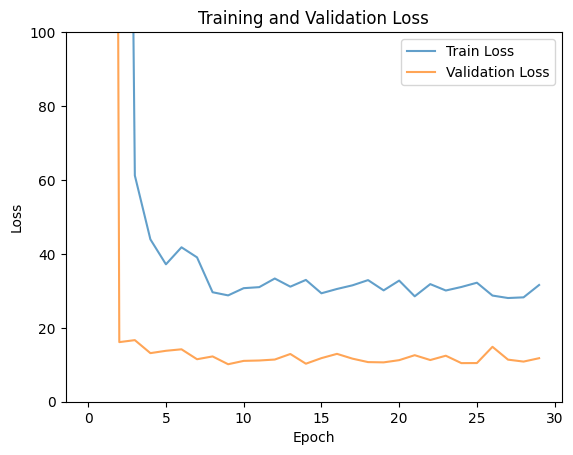

In [17]:
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.ylim(0,100)

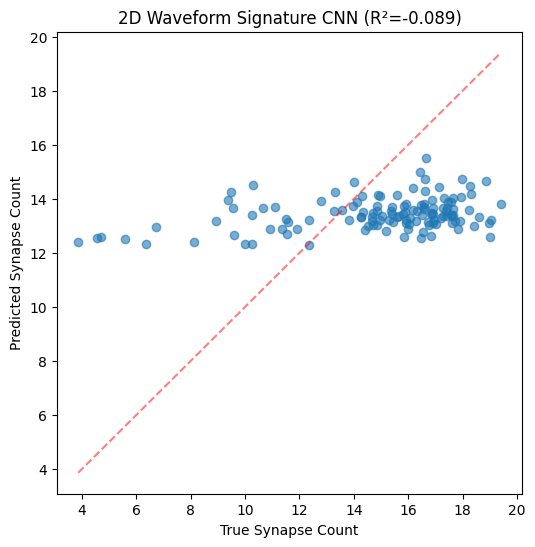

In [18]:
# Plot predictions
plt.figure(figsize=(6, 6))
plt.scatter(targets, predictions, alpha=0.6)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 'r--', alpha=0.5)
plt.xlabel('True Synapse Count')
plt.ylabel('Predicted Synapse Count')
plt.title(f'2D Waveform Signature CNN (R²={r2:.3f})')
plt.show()